# Gradient Calculations and Backpropagation

<a href="https://colab.research.google.com/github/DL4DS/sp2024_notebooks/blob/main/lecture/7_Backprop_with_Micrograd_lite_pt1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simplified implementation of a PyTorch like _backpropagation_ and automated differentiation algorithm,
e.g. _autograd_,  via a _computation graph_.

---
The code is based on Andrej Karpathy's [micrograd](https://github.com/karpathy/micrograd).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from IPython.display import Image, HTML

%matplotlib inline

## Building the `Value` Class

Like the TensorFlow `Tensor` object, we build a data wrapper as a `class` called `Value` and
build in on all the functionality we need to define a Multi-Layer Neural Network
(a.k.a. Multi-Layer Perceptron) and train it.

### Recording Child Nodes and Operations

In order to calculate the gradients, we will need to capture the computation graphs. To do that, we'll need to store pointers to the operands of each operation.

For visualization purposes we also record the symbol of the operator used, and a label for the node.

Python doesn't know how to do arithmetic with this new class, so we override methods to tell 
python how to do it.

In [2]:
# Value version 5
class Value:
                                    #     vvvvvvv  vvvvvvvv
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)   
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out                                      #  ^^^
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out                                      #  ^^^
    
    def relu(self):                                 #  vvvvvv
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

In [3]:
w = Value(4.0, label='w')
x = Value(-3.0, label='x')
b = Value(8.0, label='b')

wx = w*x ; wx.label = 'wx'
f = wx + b ; f.label = 'f'
h = f.relu() ; h.label = 'h'

In [4]:
f._prev, f._op, f.label

({Value(data=-12.0), Value(data=8.0)}, '+', 'f')

In [5]:
h._prev, h._op, h.label

({Value(data=-4.0)}, 'ReLU', 'h')

### The Compute Graph

We now have enough information stored about the compute graph to visualize it.

These are two functions to walk the graph and build sets of all nodes and edges (`trace`) and then draw them as a
directed graph (`draw_dot`).

In [6]:
# draw_dot version 1
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this no de to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

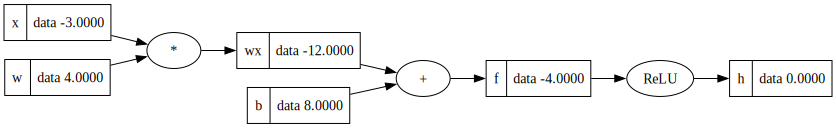

In [7]:
draw_dot(h)

Note that every value object becomes a node in the graph. The operators are also represented as a kind of fake node so they can be visualized too.

In [8]:
nodes, edges = trace(h)
print("Nodes: ", nodes)
print("Edges: ", edges)

Nodes:  {Value(data=0.0), Value(data=-4.0), Value(data=-12.0), Value(data=8.0), Value(data=-3.0), Value(data=4.0)}
Edges:  {(Value(data=-4.0), Value(data=0.0)), (Value(data=8.0), Value(data=-4.0)), (Value(data=-3.0), Value(data=-12.0)), (Value(data=-12.0), Value(data=-4.0)), (Value(data=4.0), Value(data=-12.0))}


### Recap

So far we've built a Value class and associated data structures to capture a computational graph and calculate the output based on the inputs and operations. We'll call this the __forward pass__.

But now, we're interested in calculating the gradients with respect to some of the parameters with respect to $L$. 

So next we'll update our Value class to capture the partial derivative at each node relative to L.

## Calculating Gradients


Add a gradient member variable, `grad`, to our class.

In [9]:
# Value version 6
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)   
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)   
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out
    
    def relu(self):         
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

And update `draw_dot()` to show `grad` in the node info.

In [10]:
# draw_dot version 2
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot        

And reinitialize and redraw...

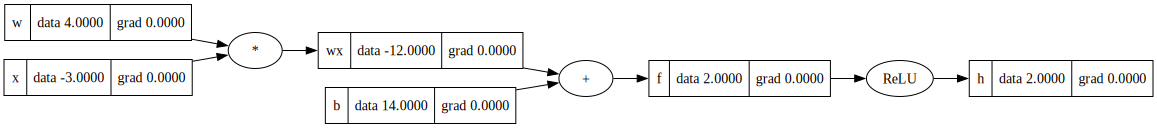

In [11]:
w = Value(4.0, label='w')
x = Value(-3.0, label='x')
b = Value(14.0, label='b')

wx = w*x ; wx.label = 'wx'
f = wx + b ; f.label = 'f'
h = f.relu() ; h.label = 'h'

draw_dot(h)

### Manual Gradient Calculation

Before we start implementing backpropagation, it is helpful to manually calculate some gradients to better understand the procedure.

For the node $h$, we trivially calculate $\frac{dh}{dh} = 1$. 

In [12]:
h.grad = 1.0

If we go backwards a step in the graph, we see that $h=\mathrm{ReLU}(f)$. Technically, 
ReLU is not differentiable at 0, but by convention we calculate

$$\frac{\partial{h}}{\partial{f}} = 
    \begin{cases}
    1 & \text{if} f \ge 0, \\
    0 & \text{if} f < 0
    \end{cases}
$$

The figure below illustrates ReLU and its derivative.

<center>

<img src="./Train2ReLUDeriv.svg" width="30%">

</center>

In [13]:
f.grad = (h.data > 0) * h.grad  # = 0 when f.data <= 0; = h.grad when h.data > 0

And we can redraw the graph above again.

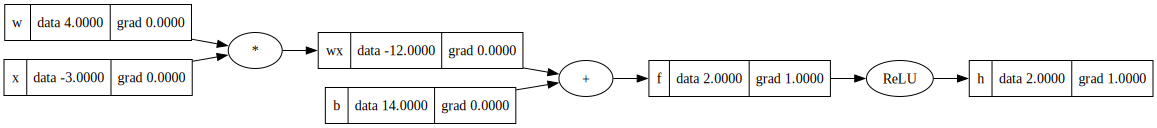

In [14]:
draw_dot(h)

Now we want to calculate

$$
\frac{\partial h}{\partial wx} = \frac{\partial h}{\partial f}\frac{\partial f}{\partial wx} \hspace{1cm} \text{and} \hspace{1cm} \frac{\partial h}{\partial b} = \frac{\partial h}{\partial f}\frac{\partial f}{\partial b}
$$

But $f = wx +b$, so

$$
\frac{\partial f}{\partial wx} = 1 \hspace{1cm} \text{and} \hspace{1cm}  \frac{\partial f}{\partial b} = 1
$$

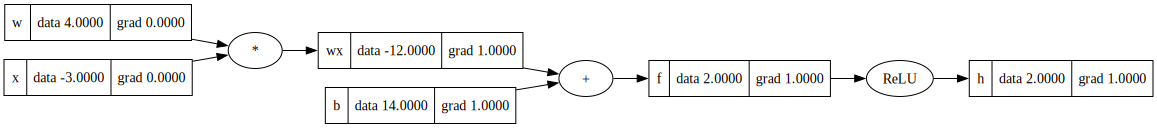

In [15]:
wx.grad = 1 * f.grad
b.grad = 1 * f.grad
draw_dot(h)

And then finally we want to calculate
$$
\frac{\partial h}{\partial w} = \frac{\partial h}{\partial f} \cdot \frac{\partial f}{\partial wx} \cdot \frac{\partial wx}{\partial w} \hspace{1cm} \text{and} \hspace{1cm} 
\frac{\partial h}{\partial w} = \frac{\partial h}{\partial f} \cdot \frac{\partial f}{\partial wx} \cdot \frac{\partial wx}{\partial w}
$$

But $wx = w * x$ so 

$$
\frac{\partial wx}{\partial w} = x \hspace{1cm} \text{and} \hspace{1cm} \frac{\partial wx}{\partial x} = w
$$

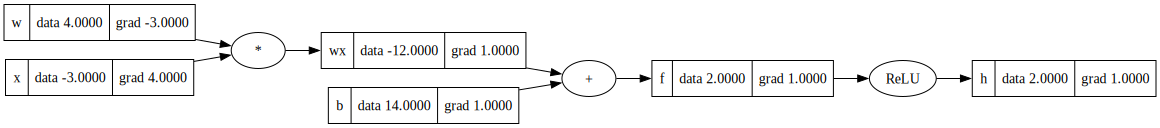

In [16]:
w.grad = wx.grad * x.data
x.grad = wx.grad * w.data
draw_dot(h)

### Recap

As you saw, we recursively went backwards through the computation graph and applied the local gradients to the gradients calculated so far to get the partial gradients. Put another we propagated this calculations backwards through the graph.

Of course, in practice, we will only need the gradients on the parameters, not the inputs, so we won't bother calculating them on inputs.

_That is the essence of Back Propagation._

## A Step in Optimization

Let's take a look at the graph again. Assume we want the value of L to _decrease_. We are free to change the values of the leaf nodes -- all the other nodes are derived from children and leaf nodes.

The leaf nodes are $a, b, c$ and $f$.

> Again, in practice we would only update the parameter leaf nodes, not the input leaf node, but we'll ignore that distinction temporarily for this exmaple.

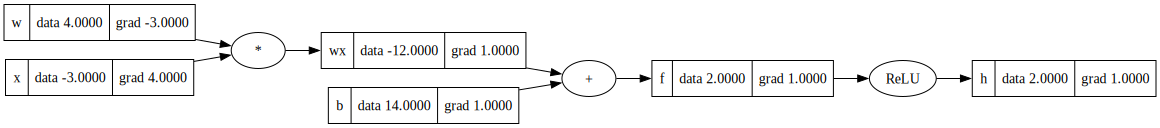

In [17]:
draw_dot(h)

Let's check the current value of L.

In [18]:
# remind ourselves what L is
print(h.data)

2.0


As we showed before, we want to nudge each of those leaf nodes by the negative
of the gradient, multiplied by a step size, $\alpha$.

$$ \phi_{n+1} = \phi_n - \alpha * \frac{\partial{L}}{\partial{\phi_n}} $$

where $n$ is the iteration number.

In [19]:
# nudge all the leaf nodes along the negative direction of the gradient
step_size = 0.01    # also called eta above

w.data -= step_size * w.grad
b.data -= step_size * b.grad


In [20]:
wx = w*x
f = wx + b
h = f.relu()

print(h.data)

1.9000000000000004


## A Single Neuron

Let's now programmatically define a single neuron with
* two inputs
* two weights (1 for each input)
* a bias
* the ReLU activation function

Recall the neuron figure above.

In [21]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

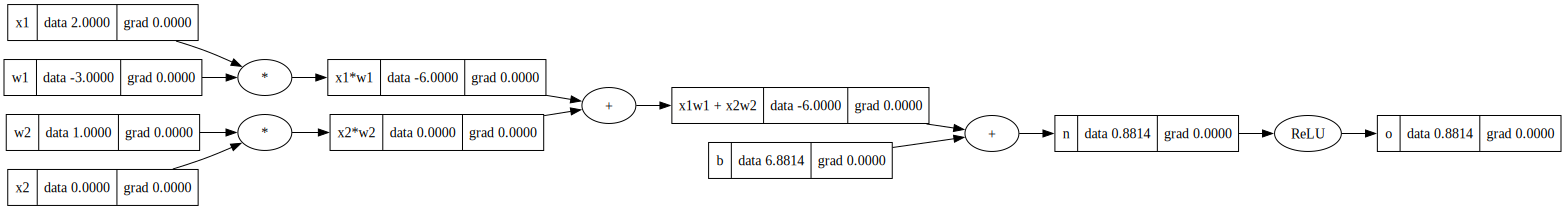

In [22]:
draw_dot(o)

## Coding Backpropagation

Now we'll update our `Value` class once more to support the backward pass.

There's a
* private `_backward()` function _in each operator_ that implements the local
step of the chain rule, and
* a `backward()` function in the class that topologically sorts the graph and calls the operator `_backward()` function starting at the end of the graph and going _backward_.

In [23]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

We redefined the class so we have to reinitialize the objects and run the operations again.

This constitutes the _forward pass_.

In [24]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(6.7, label='b')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

So we've filled the data values for all the nodes, but haven't calculated the gradients.

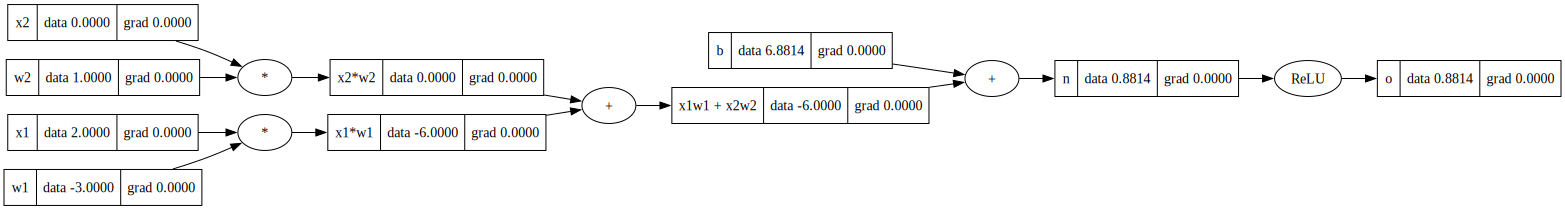

In [25]:
draw_dot(o)

Now, all we have to do is call the `backward()` method of the last node...

In [26]:
o.backward()

And voila! We have all the gradients!

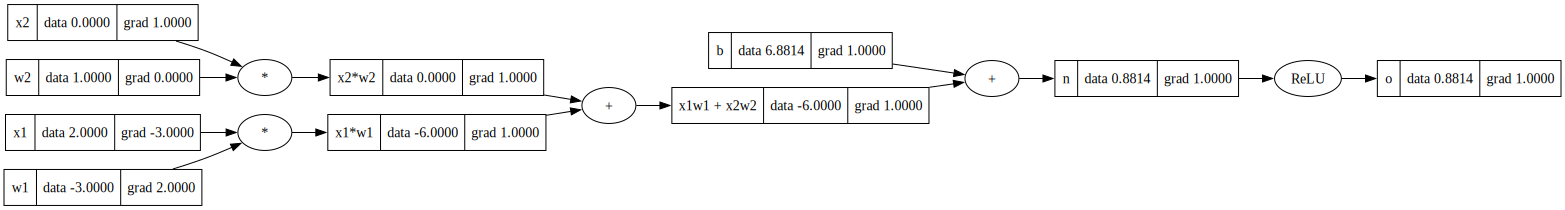

In [27]:
draw_dot(o)

### Accumulating the Gradients

The observant viewer will notice that we are accumulating the gradients.

That is to handle cases like where a `Value` object is on both sides of the operand like

In [28]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()

a

Value(data=3.0, grad=2.0)

If we didn't have the accumulation, then `a.grad = 1` instead.

Or the other case where a node goes to different operations.

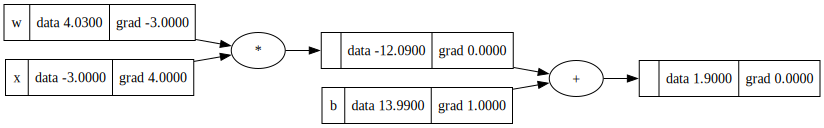

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label = 'd'
e = a + b   ; e.label = 'e'
  
draw_dot( f) 

You can see analytical verification of the above result in the note in the online book.

The risk now is that if you don't zero the gradients for the next update iteration, you will have incorrect gradients. 

> Always remember to zero the gradient in each iteration of the training loop!

## Enhancements to `Value` Class

There are still some useful operations that `Value` doesn't support, so to be more
complete we have the final version of the `Value` class below.

We added:
* `__radd__` for when the `Value` object is the right operand of an add
* `__rmul__` for when the `Value` object is the right operand of a product 
* `__pow__` to support the ** operator
* plus some others you can see below

In [30]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """Adding support for ** operator, which we'll need for the 
        squared loss function"""
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

## Comparing to PyTorch

We're using a class implementation that resembles the PyTorch implementation, and in fact we can compare our implementation with PyTorch.

In [32]:
import torch

In [33]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)

print(o.data.item())
o.backward()

print('---')
print('x2.grad', x2.grad.item())
print('w2.grad', w2.grad.item())
print('x1.grad', x1.grad.item())
print('w1.grad', w1.grad.item())

0.881373405456543
---
x2.grad 1.0
w2.grad 0.0
x1.grad -3.0
w1.grad 2.0


By default, tensors don't store gradients and so won't support backprop, so we explicitly set `requires_grad = True`.